In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [21]:
anr_tag = 'NOAK'
wacc = utils.WACC
cambium_scenario = 'MidCase'
year = 2024
results_path = f'./results/raw_results_anr_{anr_tag}_h2_wacc_{str(wacc)}.xlsx'
clean_save_path = f'./results/clean_results_anr_{anr_tag}_h2_wacc_{str(wacc)}.xlsx'

In [22]:
save_fig_path = f'./results/steel_anr_{anr_tag}_h2'

In [23]:
df = pd.read_excel(results_path, sheet_name='steel')
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)


In [24]:
anr_param = pd.read_excel('ANRs.xlsx', sheet_name=anr_tag)

### Compute deployed power at each steel plant and cumulative deployed ANR capacity

In [25]:
anr_thermal_power = anr_param[['Power in MWe', 'Reactor']]
anr_thermal_power
df = df.merge(anr_thermal_power, how='inner', left_on=['ANR type'], right_on=['Reactor'])
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df['Deployed Power (MWe)'] = df['Power in MWe']*df['# ANR modules']
df['ANR Nameplate Capacity (GWe)'] = df['Deployed Power (MWe)'].cumsum()/1000
df['Cum h2 dem (t/day)'] = df['H2 Dem. (kg/day)'].cumsum()/1000
df['Cum h2 dem (%)'] = 100*df['H2 Dem. (kg/day)'].cumsum()/df['H2 Dem. (kg/day)'].sum()

### Compute cumulative number of viable steel plants and ANR modules

In [26]:
df['Viable ANR modules count'] = df['# ANR modules'].cumsum()
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df['Viable ANR steel plants count'] = df.index+1

### Compute avoided carbon emissions 

In [27]:
demand_steel_df = pd.read_excel('./h2_demand_bfbof_steel_us_2022.xlsx', sheet_name='processed')
df = df.merge(demand_steel_df, left_on='id', right_on='Plant')

In [28]:
df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = (df['GHG QUANTITY (METRIC TONS CO2e)'] - (df['Ann. CO2 emissions (kgCO2eq/year)']/1e3))/1e6
df['Viable avoided emissions (MMT-CO2/year)'] = df['Ann. avoided CO2 emissions (MMT-CO2/year)'].cumsum()

### Compute Revenues from electricity cogeneration

In [29]:
df = utils.compute_cogen(df, surplus_cap_col_name='Surplus ANR Cap. (MWe)', state_col_name='state', \
                         cambium_scenario=cambium_scenario, year = year)
df['Net Revenues with H2 PTC with elec ($/year)'] = df['Net Revenues with H2 PTC ($/year)']+df['Electricity revenues ($/y)']

In [30]:
res_be = pd.read_csv('./results/res_be_steel.csv', index_col='RES')
def find_be_h2_demand(df, percentage):
  indleft = df['Cum h2 dem (%)'].sub(percentage).abs().idxmin()
  be = df['Breakeven price ($/MMBtu)'][indleft]
  return be
for percent in [10, 25, 50, 75, 90,100]:
  res_be.loc[str(percent), 'Breakeven price ($/MMBtu)'] = find_be_h2_demand(df, percent)
res_be

,Breakeven price ($/MMBtu)
RES,
Grid PEM,8.155361
Wind,2.114371
Solar PV-E,5.911025
SMR 89% CCUS,-6.668895
10,-16.098618
25,-15.890437
50,-15.777628
75,-15.388094
90,-15.239251


In [31]:
sheetn= 'steel'
excelf = './results/res_be_comparison.xlsx'
try:
  with pd.ExcelFile(excelf, engine='openpyxl') as xls:
    with pd.ExcelWriter(excelf, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
      res_be.to_excel(writer, sheet_name=sheetn)
except FileNotFoundError:
  res_be.to_excel(excelf, sheet_name=sheetn)

### Compute breakeven CAPEX

In [32]:
def compute_steel_capex_breakeven(anr_crf, capacity, h2_capex, anr_om, h2_om, conv, affc, h2ptc, elec, ptc=True):
  alpha = anr_crf*capacity*(1-utils.ITC_ANR)
  # Costs without SMR capex
  anrh2_costs = h2_capex+anr_om+h2_om+conv
  # BE CAPEX $/MWe
  if ptc: 
    be_capex = (affc + elec+ h2ptc - anrh2_costs)/alpha
  else:
    be_capex = (affc+ elec - anrh2_costs)/alpha
  return be_capex
df['Breakeven CAPEX ($/MWe)'] = df.apply(lambda x: compute_steel_capex_breakeven(
  x['ANR CRF'], x['Depl. ANR Cap. (MWe)'], x['H2 CAPEX ($/year)'], x['ANR O&M ($/year)'], x['H2 O&M ($/year)'], 
  x['Conversion costs ($/year)'], x['Avoided NG costs ($/year)'], x['H2 PTC Revenues ($/year)'], 
  x['Electricity revenues ($/y)']), axis=1)
df['Breakeven CAPEX wo PTC ($/MWe)'] = df.apply(lambda x: compute_steel_capex_breakeven(
  x['ANR CRF'], x['Depl. ANR Cap. (MWe)'], x['H2 CAPEX ($/year)'], x['ANR O&M ($/year)'], x['H2 O&M ($/year)'], 
  x['Conversion costs ($/year)'], x['Avoided NG costs ($/year)'], x['H2 PTC Revenues ($/year)'], 
  x['Electricity revenues ($/y)'], ptc=False), axis=1)

### Compute IRR

In [33]:
df['IRR w PTC'] = df.apply(lambda x: utils.calculate_irr(x['Initial investment ($)'], x['Electricity revenues ($/y)'], x['H2 PTC Revenues ($/year)'], x['Avoided NG costs ($/year)']), axis=1)
df['IRR wo PTC'] = df.apply(lambda x: utils.calculate_irr(x['Initial investment ($)'], x['Electricity revenues ($/y)'], x['H2 PTC Revenues ($/year)'], x['Avoided NG costs ($/year)'], ptc=False), axis=1)
df[['Conversion costs ($/year)', 'IRR w PTC', 'IRR wo PTC', 'Net Revenues with H2 PTC with elec ($/year)']].head(3)

,Conversion costs ($/year),IRR w PTC,IRR wo PTC,Net Revenues with H2 PTC with elec ($/year)
0,1.068955e+09,0.35,0.11,1.742759e+08
1,5.736752e+08,0.34,0.11,9.296560e+07
2,1.351914e+09,0.34,0.11,2.165261e+08


### Save clean version of results


In [34]:
df_clean = df[["id", 'state',  'latitude_x', 'longitude_x','Steel production capacity (ttpa)', 'Electricity revenues ($/y)',\
                'H2 Dem. (kg/day)', 'HTSE', 'ANR type', '# ANR modules', 'Net Revenues ($/year)','Breakeven CAPEX ($/MWe)',\
                  'Net Revenues with H2 PTC ($/year)','Ann. avoided CO2 emissions (MMT-CO2/year)',\
                      'Breakeven price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)',
                      'Net Revenues with H2 PTC with elec ($/year)']]

df_clean['H2 Dem. (kg/day)'] /=1e3
df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
df_clean['H2 Dem. (kg/day)'] = df_clean['H2 Dem. (kg/day)'].apply(lambda x:np.round(x,1))
df_clean['Net Revenues ($/year)'] = df_clean['Net Revenues ($/year)'].apply(lambda x: np.round(x/1e6,1))
df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']= df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'].apply(lambda x: np.round(x,1))
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Net Revenues ($/year)']/df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Avoided cost of CO2 ($/ton)'].apply(lambda x:np.round(np.abs(x),1))
df_clean['Breakeven price ($/MMBtu)'] = df_clean['Breakeven price ($/MMBtu)'].apply(lambda x : np.round(x,1))
df_clean.rename(columns={'H2 Dem (kg/day)': 'Demand (MT H2/day)', 
                         'ANR type': 'ANR', 'latitude_x':'latitude', 'longitude_x':'longitude',
                         '# ANR modules': '#'}, inplace=True)
df.rename(columns={'latitude_x':'latitude', 'longitude_x':'longitude'}, inplace=True)

In [35]:

sheet_name = 'steel'
excel_file = clean_save_path
try:
# Load the existing Excel file
  with pd.ExcelFile(excel_file, engine='openpyxl') as xls:
      # Check if the sheet exists
      if sheet_name in xls.sheet_names:
          # If the sheet exists, replace the data
          with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
              df.to_excel(writer, sheet_name=sheet_name, index=False)
      else:
          # If the sheet doesn't exist, create a new sheet
          with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
              df.to_excel(writer, sheet_name=sheet_name, index=False)
except FileNotFoundError:
    # If the file doesn't exist, create a new one and write the DataFrame to it
    df.to_excel(excel_file, sheet_name=sheet_name, index=False)

### Plots

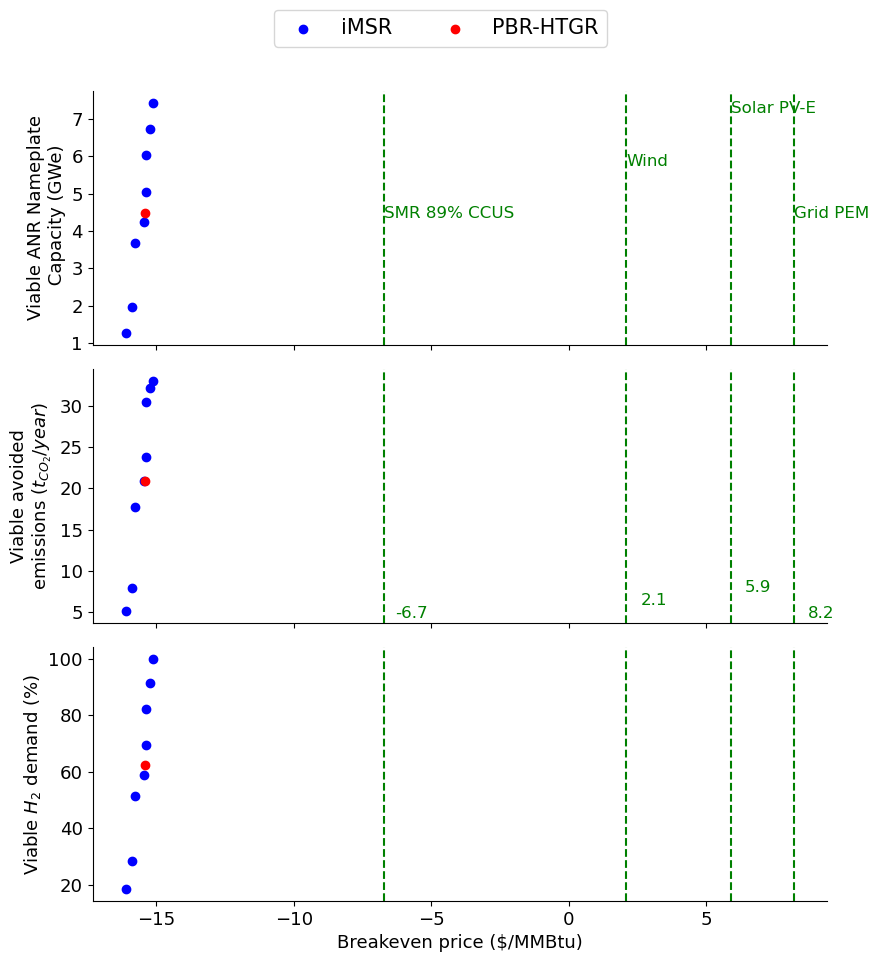

In [36]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 13

# Create subplots
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(9, 9))

# Get unique ANR types and assign colors
anr_types = df['ANR type'].unique()

colors = ['blue', 'red', 'black']  # Adjust the colors according to the unique ANR types
# Initialize empty handles for legend
handles = []
# Plotting the data as scatter plots with different colors for each ANR type
labels = {'ANR Nameplate Capacity (GWe)': 'Viable ANR Nameplate\n Capacity (GWe)',
            'Viable avoided emissions (MMT-CO2/year)': 'Viable avoided\n'r'emissions ($t_{CO_2}/year$)',
            'Cum h2 dem (%)':r'Viable $H_2$ demand (%)'}
for i, col in enumerate(['ANR Nameplate Capacity (GWe)', 'Viable avoided emissions (MMT-CO2/year)', 'Cum h2 dem (%)']):
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs[i].scatter(subset['Breakeven price ($/MMBtu)'], subset[col], color=color, label=f'{anr_type}')
    axs[i].set_ylabel(labels[col])

    # Remove the top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)


    # Adding vertical lines
    import utils
    res_be = pd.read_csv('./results/res_be_steel.csv')
    res_be['Breakeven price ($/MMBtu)'] = res_be['Breakeven price ($/MMBtu)']
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    coal_vertical_lines = [195]
    #for line in coal_vertical_lines:
     #   axs[i].axvline(x=line, linestyle='--', color='grey')
    for l,line in enumerate(res_vert_lines):
        axs[i].axvline(x=line, linestyle='--',color='green')

res_labels = res_be['RES']
count = 0
for x, label in zip(res_vert_lines, res_labels):
    axs[0].text(x, (axs[0].get_ylim()[1]+axs[0].get_ylim()[0])/2+1.4*np.mod(count,3), label, fontsize=12, color='green')
    axs[1].text(x+1, axs[1].get_ylim()[0]+2+1.6*np.mod(count,3), str(x), color='green', fontsize=12, va='top',ha='center')
    count+=1


# Setting the title and labels
plt.xlabel('Breakeven price ($/MMBtu)')


# Add a common legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,  bbox_to_anchor=(.5,1.08),loc='upper center',ncol=len(anr_types))
fig.tight_layout()
#plt.show()
plt.savefig(save_fig_path+'.png')

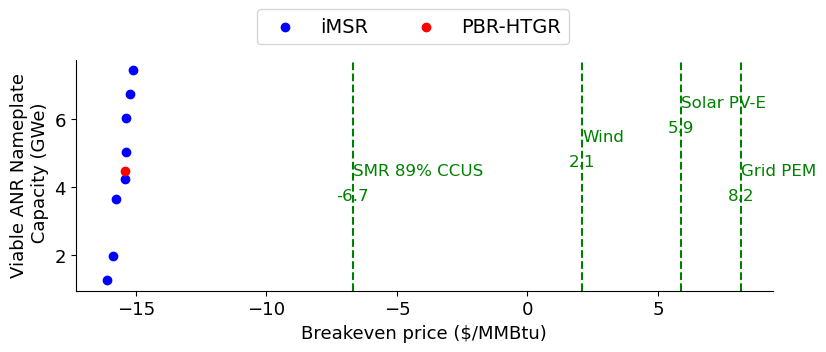

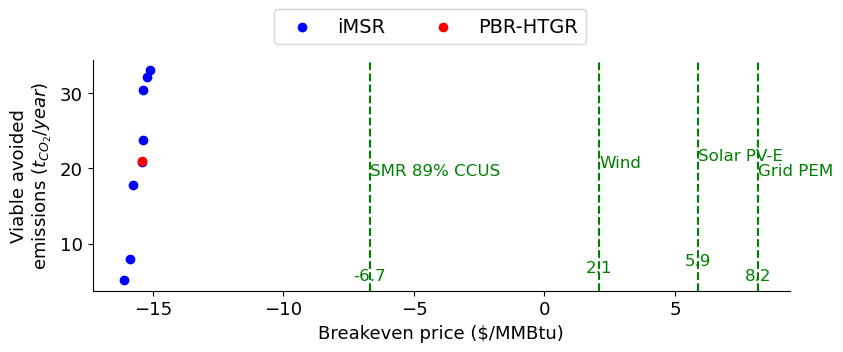

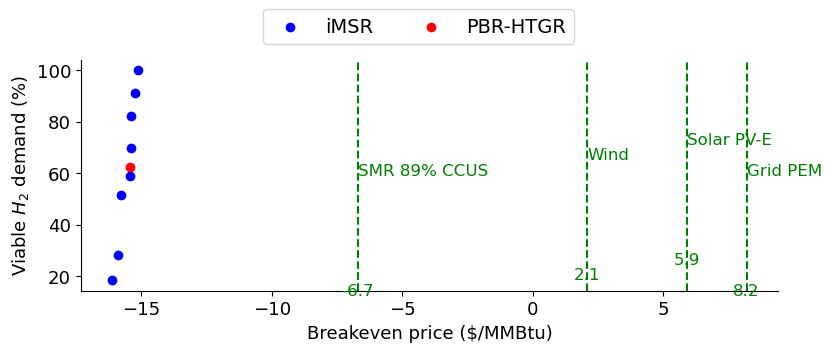

In [37]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 13
labels = {'ANR Nameplate Capacity (GWe)': ['Viable ANR Nameplate\n Capacity (GWe)', 'capacity'],
            'Viable avoided emissions (MMT-CO2/year)': ['Viable avoided\n'r'emissions ($t_{CO_2}/year$)', 'emission'],
            'Cum h2 dem (%)':[r'Viable $H_2$ demand (%)', 'h2_demand']}

def plot_against_be(df, col_name, y_label, save_label):
    anr_types = df['ANR type'].unique()
    colors = ['blue', 'red', 'black'] 
    fig, axs = plt.subplots(figsize=(9, 3))
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs.scatter(subset['Breakeven price ($/MMBtu)'], subset[col_name], color=color, label=f'{anr_type}')
    axs.set_ylabel(y_label)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)

    # Adding vertical lines and labels for competing RES 
    res_be = pd.read_csv('./results/res_be_steel.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    for l,line in enumerate(res_vert_lines):
        axs.axvline(x=line, linestyle='--',color='green')
        res_labels = res_be['RES']
    count = 0
    for x, label in zip(res_vert_lines, res_labels):
        if save_label =='h2_demand': modulo=6 
        else: modulo=1
        axs.text(x, (axs.get_ylim()[1]+axs.get_ylim()[0])/2+modulo*np.mod(count,3), label, fontsize=12, color='green')
        axs.text(x, axs.get_ylim()[0]+modulo*np.mod(count,3)+3, str(x), color='green', fontsize=12, va='top',ha='center')
        count+=1
        # Setting the title and labels
    axs.set_xlabel('Breakeven price ($/MMBtu)')
    handles, labels = axs.get_legend_handles_labels()
    fig.legend(handles, labels,  bbox_to_anchor=(.5,1.08),loc='upper center', ncol=len(anr_types))
    fig.savefig(save_fig_path+'_'+save_label+'.png',  bbox_inches='tight')

for col_name, label_list in labels.items():
    plot_against_be(df, col_name, y_label=label_list[0], save_label=label_list[1])
